In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install pyodbc
%pip install geopandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import subprocess
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import multiprocessing
from joblib import Parallel, delayed

## Air toxics data for 2017

In [4]:
# Open the Air toxics data for 2017 Data
mdb_file = "ConcExpRisk_tract_poll_WA.mdb"

list_tables = subprocess.run(['mdb-tables', '-1', mdb_file], capture_output=True, text=True)
tables = list_tables.stdout.splitlines()

In [5]:
# Ambient Concentration (ug/m3)
table_name = tables[0]
export_process = subprocess.run(['mdb-export', mdb_file, table_name], capture_output=True, text=True)
csv_data = export_process.stdout
ambient_concentration_df = pd.read_csv(io.StringIO(csv_data))

In [6]:
# Only keep needed cols
total_conc_df = ambient_concentration_df[['Tract', 'Population', 'Pollutant Name', 'Total Conc', 'County']]

## Mortality data for 2017

In [7]:
file_path = "/Users/derek/Library/CloudStorage/OneDrive-WashingtonStateUniversity(email.wsu.edu)/Shared Files/cardiovascular disease.csv"
mortality_data_df = pd.read_csv(file_path)

## Preprocess the data

In [27]:
# Combine the data
combined_all_df = mortality_data_df.merge(ambient_concentration_df, on='Tract', how='left')
combined_total_df = mortality_data_df.merge(total_conc_df, on='Tract', how='left')

In [15]:
# Drop duplicate id's
cleaned_df = combined_total_df.copy()
cleaned_df.drop_duplicates(subset="id", keep="first").reset_index(drop=True)

,id,Tract,age,sex,race,education,marital,geography,Population,Pollutant Name,Total Conc,County
0,2017000003,53011040411,83,M,NH.White,NoHS,Married,Metropolitan,1874,"1,1-DIMETHYLHYDRAZINE",0.0,Clark
1,2017000004,53077002101,61,M,NH.White,HS,Married,Suburban,1950,"1,1-DIMETHYLHYDRAZINE",0.0,Yakima
2,2017000006,53077000400,96,F,NH.White,HS,Widowed,Metropolitan,7423,"1,1-DIMETHYLHYDRAZINE",0.0,Yakima
3,2017000009,53005011100,81,M,NH.White,HS,Married,Metropolitan,7365,"1,1-DIMETHYLHYDRAZINE",0.0,Benton
4,2017000010,53005011503,89,M,NH.White,College.Associate,Widowed,Metropolitan,9380,"1,1-DIMETHYLHYDRAZINE",0.0,Benton
...,...,...,...,...,...,...,...,...,...,...,...,...
15415,2017092441,53015001100,67,F,Unknown,HS,DivorcedSeparated,Metropolitan,5856,"1,1-DIMETHYLHYDRAZINE",0.0,Cowlitz
15416,2017092446,53029971400,82,M,Unknown,HS,Widowed,Metropolitan,4400,"1,1-DIMETHYLHYDRAZINE",0.0,Island
15417,2017092449,53011040412,41,M,Unknown,HS,DivorcedSeparated,Metropolitan,4333,"1,1-DIMETHYLHYDRAZINE",0.0,Clark
15418,2017092450,53011041007,74,M,Unknown,HS,Married,Metropolitan,3066,"1,1-DIMETHYLHYDRAZINE",0.0,Clark


In [18]:
# Configure ColumnTransformer to preprocess numerical and categorical features
qualitative_values = ['sex', 'race', 'education', 'marital', 'geography']
quantitative_values = ['Total Conc']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', quantitative_values),
        ('cat', OneHotEncoder(), qualitative_values)
    ])

In [20]:
# Split the data into training and testing sets
X = cleaned_df[['Total Conc', 'sex', 'race', 'education', 'marital', 'geography']]
Y = cleaned_df['age']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Train the regression model

In [21]:
# Create a pipeline to preprocess data and train a linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [22]:
# Fit the model
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Total Conc']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'race', 'education',
                                                   'marital', 'geography'])])),
                ('regressor', LinearRegression())])

## Evaluate the model

In [23]:
Y_pred = model.predict(X_test)

In [24]:
# Calculate metrics
mean_abs_err = mean_absolute_error(Y_test, Y_pred)
mean_sqr_err = mean_squared_error(Y_test, Y_pred)
rt_mean_sqr_err = np.sqrt(mean_sqr_err)
r2 = r2_score(Y_test, Y_pred)

In [25]:
print(f'Model Metrics:')
print(f'Mean Absolute Error: {mean_abs_err:.2f}')
print(f'Mean Squared Error: {mean_sqr_err:.2f}')
print(f'Root Mean Squared Error: {rt_mean_sqr_err:.2f}')
print(f'R^2 Score: {r2:.2f}')

Model Metrics:
Mean Absolute Error: 8.83
Mean Squared Error: 131.84
Root Mean Squared Error: 11.48
R^2 Score: 0.35


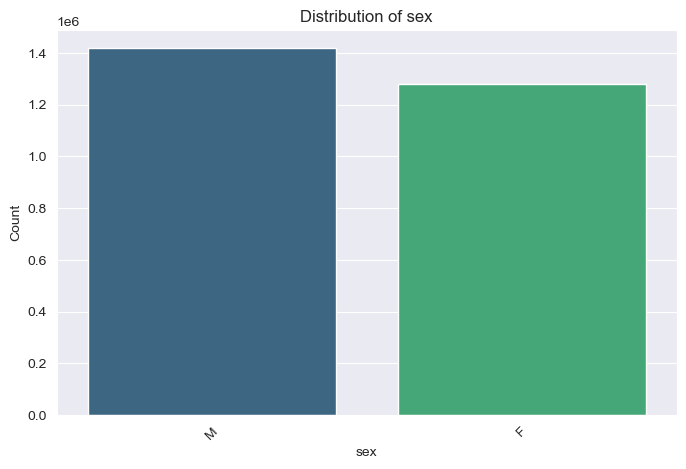

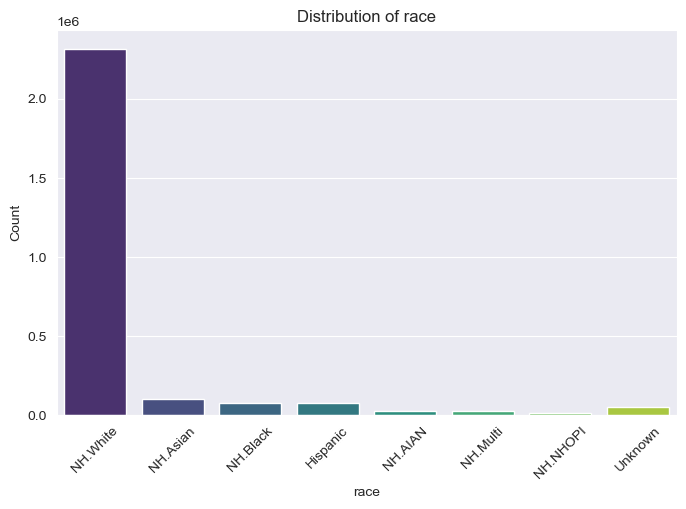

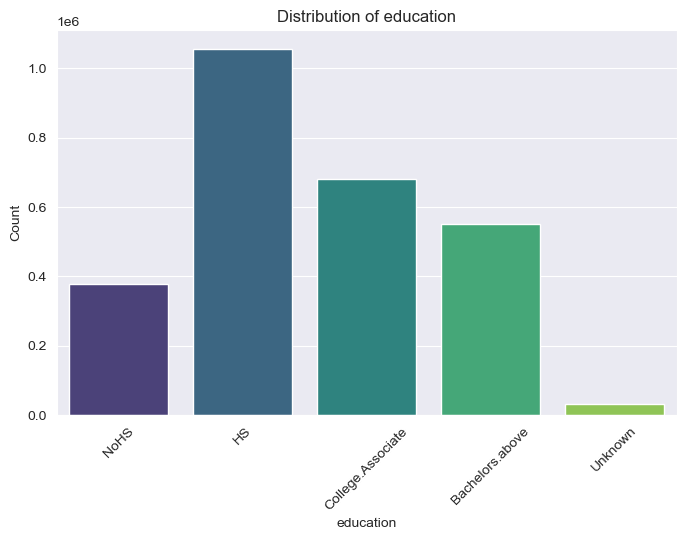

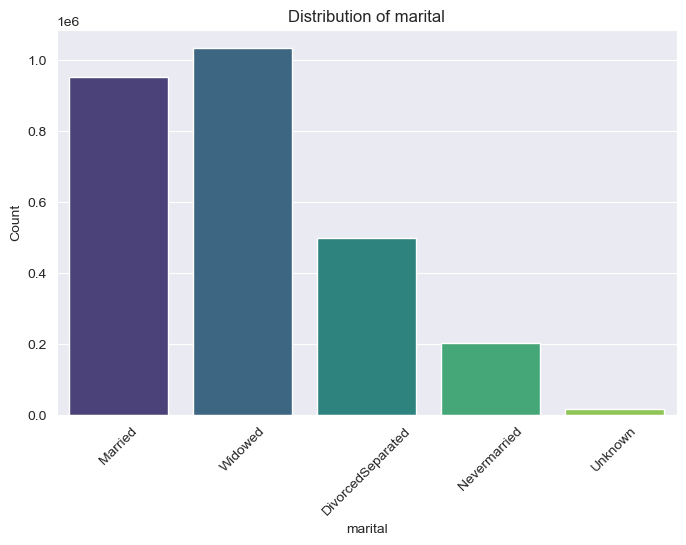

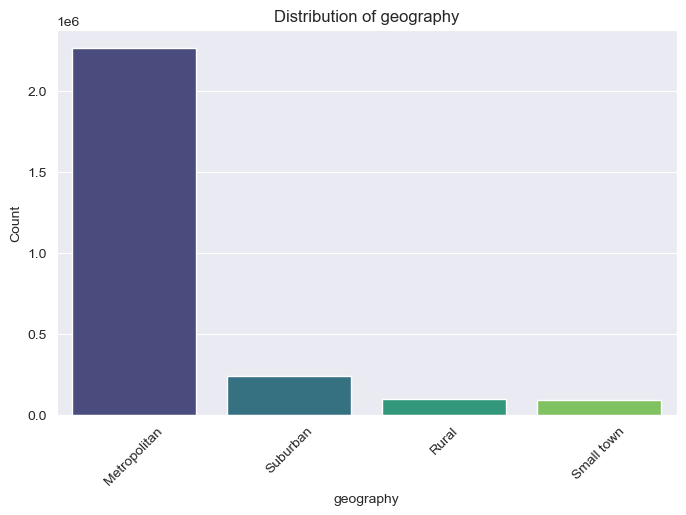

In [28]:
# Countplot for categorical variables
for col in qualitative_values:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=combined_total_df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

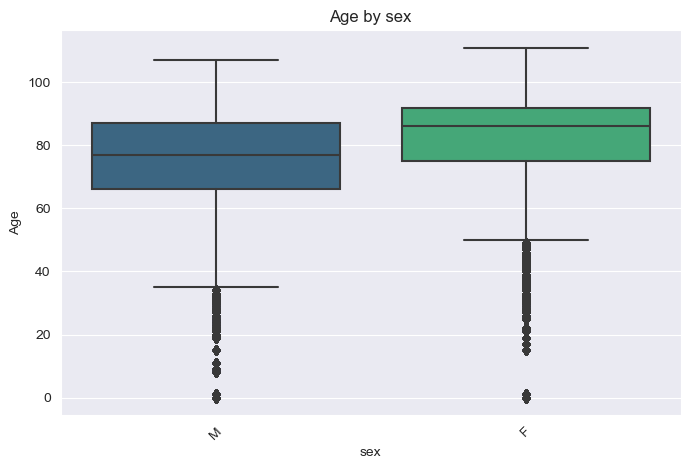

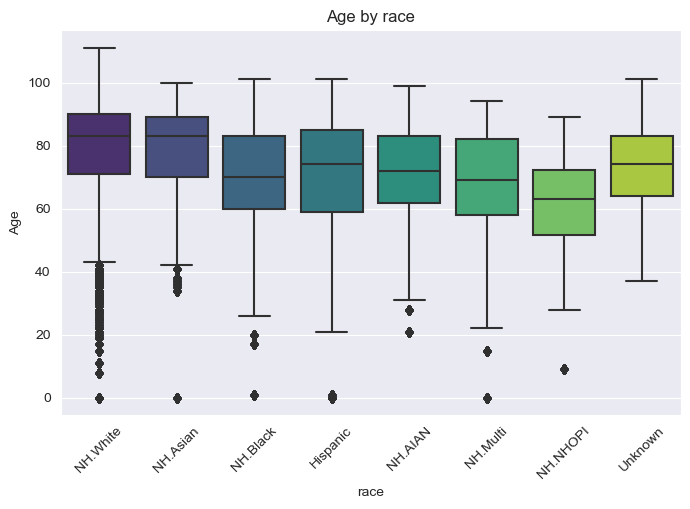

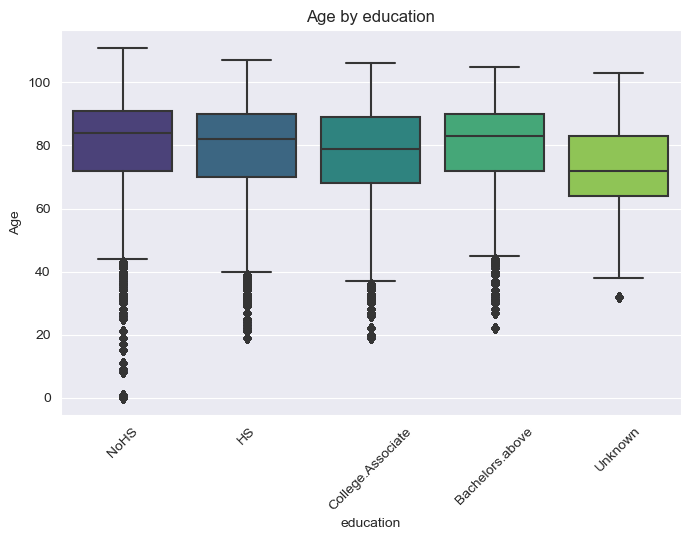

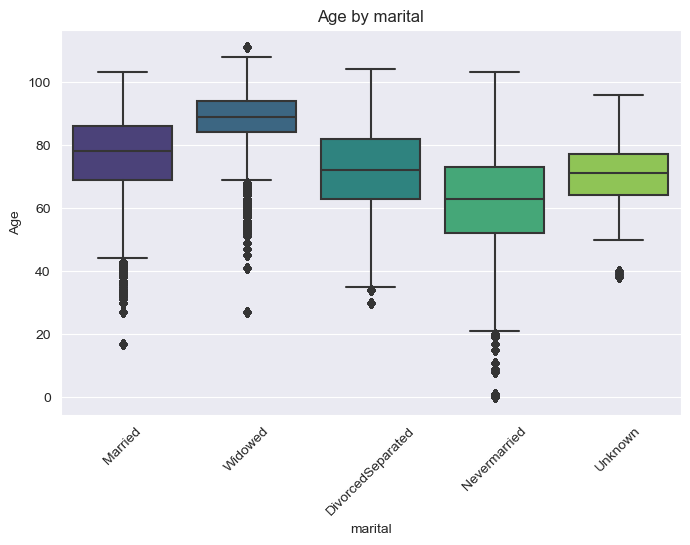

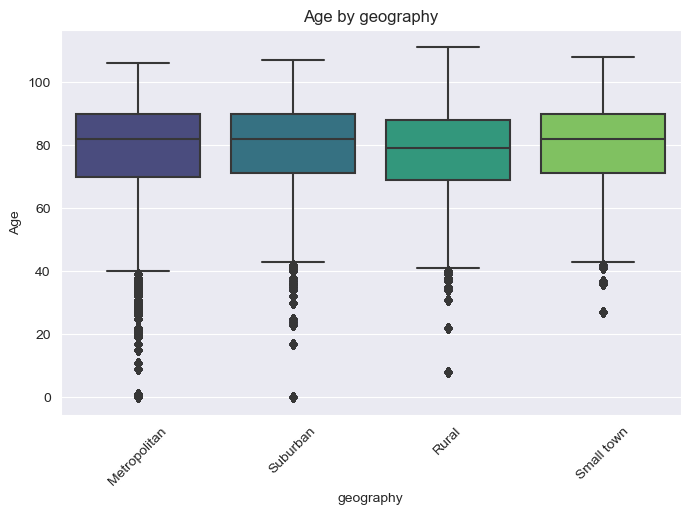

In [29]:
# Boxplot for categorical variables
for col in qualitative_values:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=combined_total_df, x=col, y='age', palette='viridis')
    plt.title(f'Age by {col}')
    plt.xlabel(col)
    plt.ylabel('Age')
    plt.xticks(rotation=45)
    plt.show()

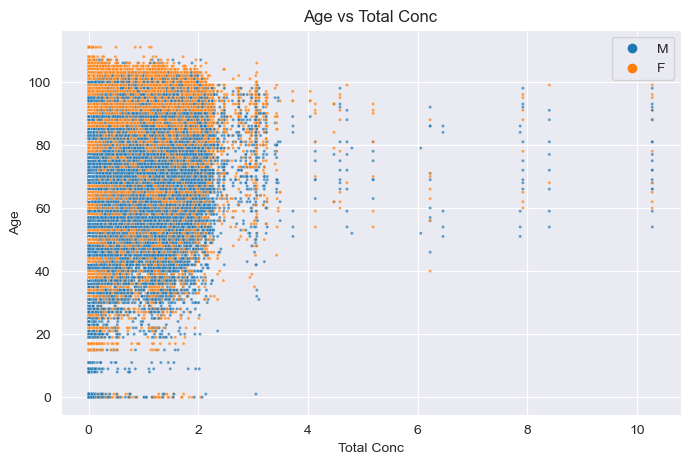

In [30]:
# Scatterplot for numerical variables
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined_total_df, x='Total Conc', y='age', alpha=0.7, hue='sex', s=5)
plt.title('Age vs Total Conc')
plt.xlabel('Total Conc')
plt.ylabel('Age')
plt.legend()
plt.show()

In [31]:
# Grouped Statistics
for col in qualitative_values:
    print(f"\nGrouped Statistics for {col}")
    print(combined_total_df.groupby(col)['age'].describe())


Grouped Statistics for sex
         count       mean        std  min   25%   50%   75%    max
sex                                                               
F    1280825.0  82.276404  13.393673  0.0  75.0  86.0  92.0  111.0
M    1417675.0  75.640415  14.160509  0.0  66.0  77.0  87.0  107.0

Grouped Statistics for race
              count       mean        std   min    25%   50%    75%    max
race                                                                      
Hispanic    77000.0  70.718182  17.987932   0.0  59.00  74.0  85.00  101.0
NH.AIAN     29400.0  70.166667  16.318419  21.0  61.75  72.0  83.00   99.0
NH.Asian   103950.0  78.594276  14.099834   0.0  70.00  83.0  89.00  100.0
NH.Black    75600.0  70.261574  15.549266   1.0  60.00  70.0  83.00  101.0
NH.Multi    25550.0  67.534247  17.680210   0.0  58.00  69.0  82.00   94.0
NH.NHOPI    16100.0  61.869565  14.989024   9.0  51.75  63.0  72.25   89.0
NH.White  2317525.0  79.830174  13.563352   0.0  71.00  83.0  90.00  111.0


## Interpret the reults

In [32]:
# Retrieve model coefficients for interpretation
encoded_features = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(qualitative_values)
feature_names = quantitative_values + list(encoded_features)

coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

results_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(results_df)

                        Feature  Coefficient
0                    Total Conc     0.076026
1                         sex_F     1.123845
2                         sex_M    -1.123845
3                 race_Hispanic    -0.454636
4                  race_NH.AIAN    -0.561127
5                 race_NH.Asian     4.038155
6                 race_NH.Black     0.469769
7                 race_NH.Multi    -2.674461
8                 race_NH.NHOPI    -7.969315
9                 race_NH.White     6.164525
10                 race_Unknown     0.987091
11    education_Bachelors.above     1.867996
12  education_College.Associate    -1.362797
13                 education_HS    -0.767469
14               education_NoHS     0.452148
15            education_Unknown    -0.189877
16    marital_DivorcedSeparated    -1.721031
17              marital_Married     2.464223
18         marital_Nevermarried   -11.042199
19              marital_Unknown    -2.637455
20              marital_Widowed    12.936462
21       g

## Heatmap

In [33]:
heatmap_df = total_conc_df.groupby('County').size().reset_index(name='Count')

In [34]:
us_counties = gpd.read_file('us_counties.geojson')
wa_counties = us_counties[us_counties['STATEFP'] == '53']

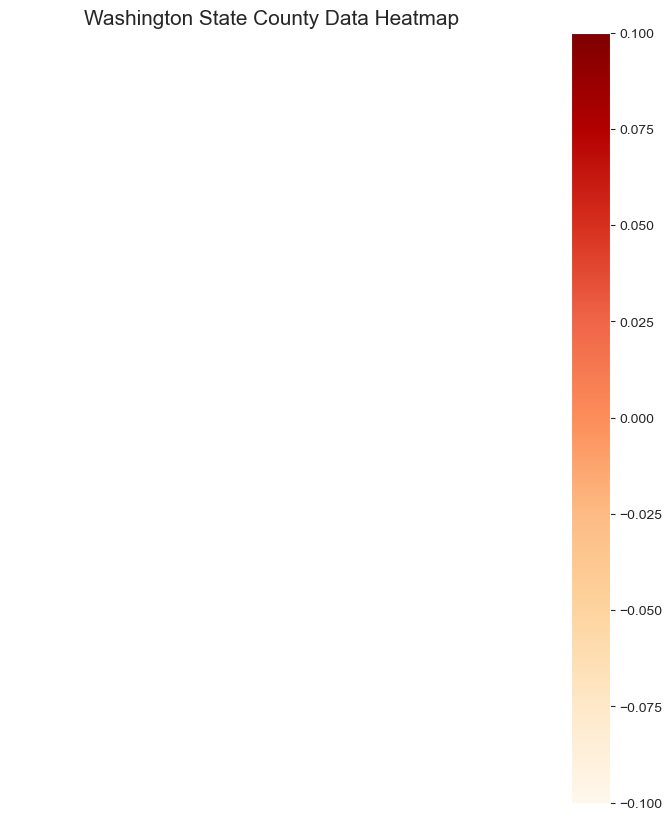

In [35]:
# Standardize county names to lowercase
heatmap_df.loc['County'] = heatmap_df['County'].str.lower()
wa_counties = wa_counties.copy()
wa_counties['NAME'] = wa_counties['NAME'].str.lower()

# Merge DataFrames on county names
merged = wa_counties.set_index('NAME').join(heatmap_df.set_index('County'))

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the choropleth map
merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Remove axis
ax.axis('off')

# Add a title
ax.set_title('Washington State County Data Heatmap', fontdict={'fontsize': '15', 'fontweight': '3'})

# Show the plot
plt.show()


## Machine Learning

In [38]:
df = combined_total_df[['age', 'sex', 'race', 'education', 'marital', 'geography', 'Total Conc']].copy()
n_samples = len(df)

In [11]:
class ParallelAgePredictionModel:
    def __init__(self, n_jobs=-1):
        # Determine optimal number of cores
        self.n_jobs = n_jobs if n_jobs != -1 else multiprocessing.cpu_count()
        
        # Identify column types
        self.numeric_features = ['Total Conc']
        self.categorical_features = ['sex', 'race', 'education', 'marital', 'geography']
        
        # Create preprocessing steps
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_features)
            ])
        
        # Create the full pipeline with parallel RandomForestRegressor
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', RandomForestRegressor(
                n_estimators=5, 
                random_state=42, 
                n_jobs=self.n_jobs  # Parallel tree building
            ))
        ])
        
    def parallel_cross_validation(self, X, y, cv=5):
        def single_fold_score(train_index, test_index):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Clone pipeline to avoid state interference
            fold_pipeline = self.pipeline.set_params()
            
            # Fit and predict
            fold_pipeline.fit(X_train, y_train)
            y_pred = fold_pipeline.predict(X_test)
            
            return mean_absolute_error(y_test, y_pred)
        
        # Split indices for cross-validation
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        # Parallel cross-validation
        cv_scores = Parallel(n_jobs=self.n_jobs)(
            delayed(single_fold_score)(train_index, test_index)
            for train_index, test_index in kf.split(X)
        )
        
        return np.array(cv_scores)
    
    def train(self, X, y):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Fit the pipeline
        self.pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred = self.pipeline.predict(X_test)
        
        # Performance metrics
        print(f"Number of Parallel Jobs: {self.n_jobs}")
        print("Model Performance Metrics:")
        print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
        print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
        print(f"R-squared Score: {r2_score(y_test, y_pred):.2f}")
        
        # Parallel Cross-Validation
        cv_scores = self.parallel_cross_validation(X, y)
        print("\nParallel Cross-Validation Scores:")
        print(f"MAE: {-cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
        
        return self
    
    def parallel_prediction(self, X):
        # Use joblib for parallel predictions
        def predict_chunk(chunk):
            return self.pipeline.predict(chunk)
        
        # Split the data into chunks for parallel processing
        chunk_size = max(1, len(X) // (self.n_jobs * 2))
        chunks = [X.iloc[i:i+chunk_size] for i in range(0, len(X), chunk_size)]
        
        # Parallel predictions
        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(predict_chunk)(chunk) for chunk in chunks
        )
        
        # Combine predictions
        return np.concatenate(predictions)
    
    def feature_importance(self):
        # Get feature names after preprocessing
        feature_names = (
            self.numeric_features + 
            list(self.pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(self.categorical_features))
        )
        
        # Extract feature importances
        importances = self.pipeline.named_steps['regressor'].feature_importances_
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\nFeature Importances:")
        print(importance_df)
        
        return importance_df


# Set up multiprocessing to avoid issues with parallel processing
multiprocessing.freeze_support()

# Time the entire process
import time
start_time = time.time()

# Initialize and train the model with parallel processing
model = ParallelAgePredictionModel(n_jobs=-1)  # Use all available cores

# Separate features and target
X = df.drop('age', axis=1)
y = df['age']

# Train the model
model.train(X, y)

# Get feature importances
model.feature_importance()

# Example parallel prediction
new_data = X.sample(10000)
predictions = model.parallel_prediction(new_data)
print("\nParallel Prediction Sample:")
print(f"Predicted {len(predictions)} ages")

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")

Number of Parallel Jobs: 22
Model Performance Metrics:
Mean Absolute Error: 9.32
Mean Squared Error: 152.89
R-squared Score: 0.24

Parallel Cross-Validation Scores:
MAE: -9.32 (+/- 0.01)

Feature Importances:
                        feature  importance
0                    Total Conc    0.392099
20              marital_Widowed    0.378533
18         marital_Nevermarried    0.079559
9                 race_NH.White    0.029018
17              marital_Married    0.018385
2                         sex_M    0.015015
1                         sex_F    0.012844
11    education_Bachelors.above    0.011576
12  education_College.Associate    0.007451
14               education_NoHS    0.006785
13                 education_HS    0.006214
5                 race_NH.Asian    0.005773
24           geography_Suburban    0.004654
22              geography_Rural    0.004247
21       geography_Metropolitan    0.003827
15            education_Unknown    0.003428
23         geography_Small town    0.003170